# Chapter 5: Interpretable Models

In [39]:
# Imports

from preprocess_bike_data import data_pipeline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Reading in the Data

In [87]:
df = data_pipeline()

<AxesSubplot:>

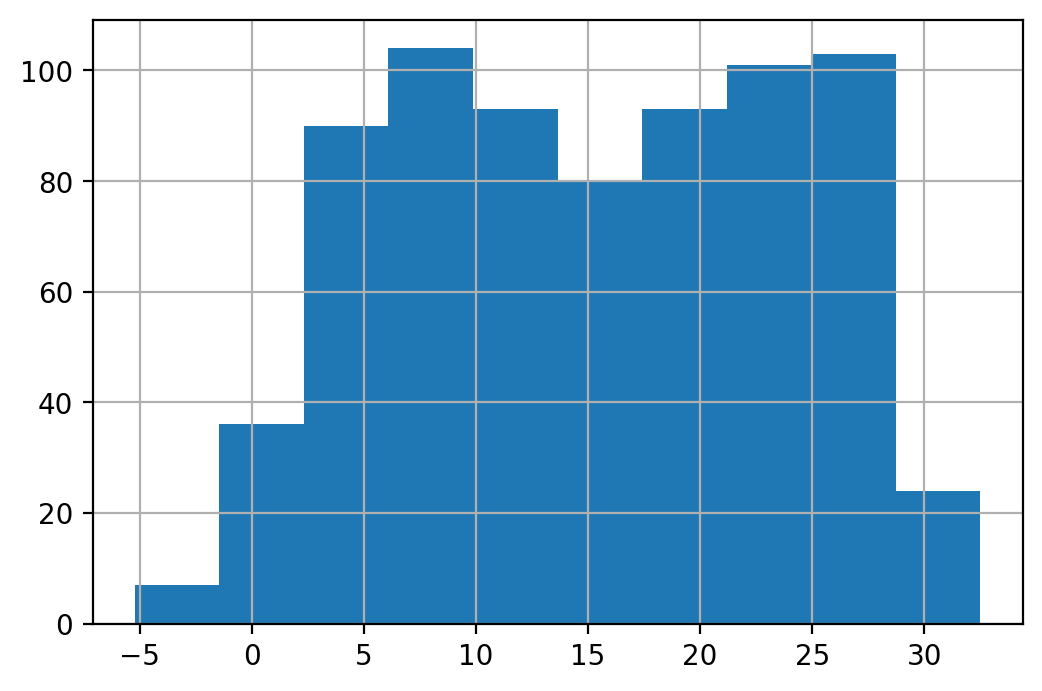

In [84]:
df['temp'].hist()

## Data Preprocessing

In [41]:
# Dropping columns not used

sub_features = ['season', 'holiday','workingday', 'weathersit']
df.drop(sub_features + ['yr', 'mnth', 'weekday'], inplace=True, axis=1)

In [85]:
# Scaling the data

from sklearn.preprocessing import MinMaxScaler

for col in ['temp', 'hum', 'windspeed']:
    sc = MinMaxScaler()
    df[col] = sc.fit_transform(df[col].values.reshape(-1,1))

<AxesSubplot:>

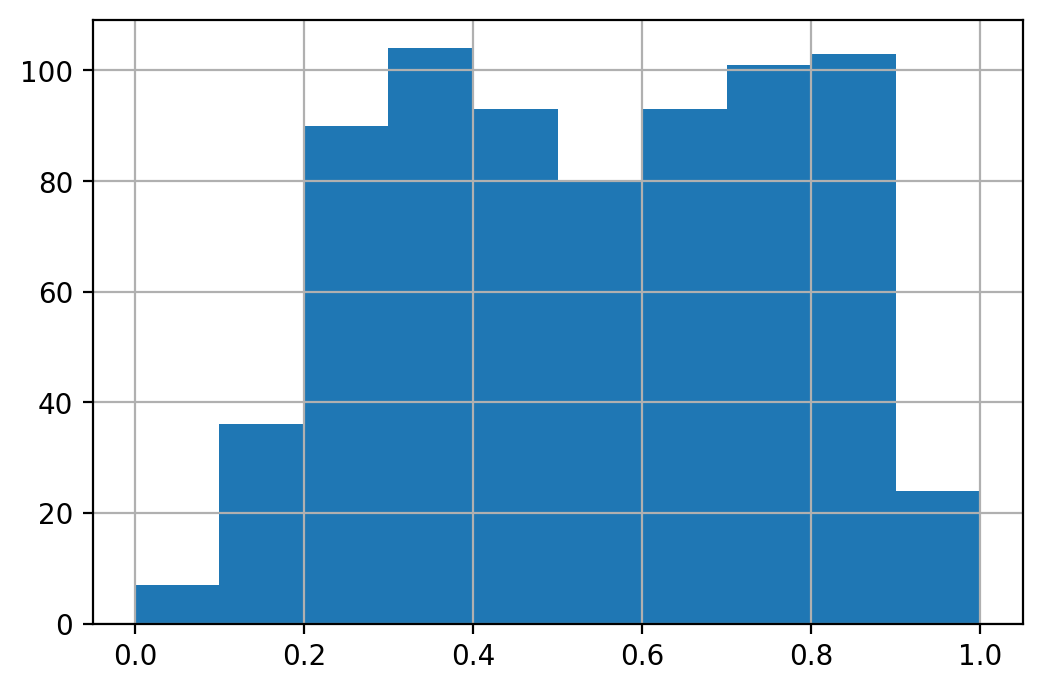

In [86]:
df['temp'].hist()

In [88]:
# Scaling the data

from sklearn.preprocessing import StandardScaler

for col in ['temp', 'hum', 'windspeed']:
    sc = StandardScaler()
    df[col] = sc.fit_transform(df[col].values.reshape(-1,1))

<AxesSubplot:>

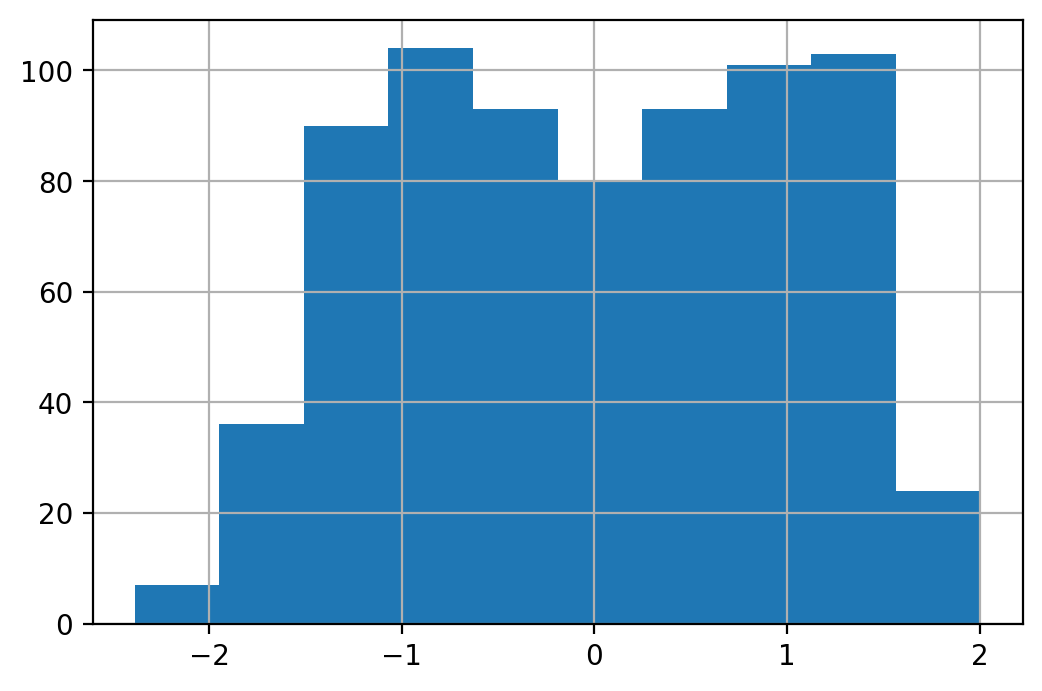

In [89]:
df['temp'].hist()

## Modeling

### Establishing Features and Target

In [81]:
features = [col for col in df.columns if col != 'cnt']
target = 'cnt'

### Linear Regression

In [82]:
import statsmodels.api as sm

model = sm.OLS(df['cnt'], df[features])
results = model.fit()
results.params

temp                                 13906.385697
hum                                     -0.011202
windspeed                            -4637.831297
days_since_2011                          0.170152
season_SPRING                            0.001370
season_SUMMER                           -0.005088
season_WINTER                           -0.015343
holiday_NO HOLIDAY                       0.000317
workingday_WORKING DAY                   0.007459
weathersit_MISTY                        -0.001241
weathersit_RAIN/SNOW/STORM              -0.000366
effect_temp                             -2.211217
effect_hum                               4.350980
effect_windspeed                        -4.384535
effect_days_since_2011                   0.899605
effect_season_SPRING                     0.805641
effect_season_SUMMER                     1.209261
effect_season_WINTER                     2.555308
effect_holiday_NO HOLIDAY                0.466043
effect_workingday_WORKING DAY            0.965278


In [90]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     251.2
Date:                Sun, 04 Dec 2022   Prob (F-statistic):          1.05e-237
Time:                        11:10:01   Log-Likelihood:                -5993.0
No. Observations:                 731   AIC:                         1.201e+04
Df Residuals:                     719   BIC:                         1.207e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
temp                               1.391e+04   2094.125      6.641      0.000    9795.056     1.8e+04
hum                                  -0.0112      0.002     -5.483      0.000      -0.015      -0.007
windspeed                         -4637.8313    698.398     -6.641      0.000   -6008.975   -3266.688
days_since_2011                       0.1702      0.006     28.507      0.000       0.158       0.182
season_SPRING                         0.0014      0.000      4.309      0.000       0.001       0.002
season_SUMMER                        -0.0051      0.002     -2.141      0.033      -0.010      -0.000
season_WINTER                        -0.0153      0.004     -3.840      0.000      -0.023      -0.007
holiday_NO HOLIDAY                    0.0003   9.38e-05      3.375      0.001       0.000       0.001
workingday_WORKING DAY                0.0075      0.004      1.705      0.089      -0.001       0.016
weathersit_MISTY                     -0.0012      0.000     -4.333      0.000      -0.002      -0.001
weathersit_RAIN/SNOW/STORM           -0.0004   4.31e-05     -8.503      0.000      -0.000      -0.000
effect_temp                          -2.2112      0.487     -4.538      0.000      -3.168      -1.255
effect_hum                            4.3510      0.794      5.483      0.000       2.793       5.909
effect_windspeed                     -4.3845      0.855     -5.126      0.000      -6.064      -2.705
effect_days_since_2011                0.8996      0.032     28.507      0.000       0.838       0.962
effect_season_SPRING                  0.8056      0.187      4.309      0.000       0.439       1.173
effect_season_SUMMER                  1.2093      0.565      2.141      0.033       0.100       2.318
effect_season_WINTER                  2.5553      0.665      3.840      0.000       1.249       3.862
effect_holiday_NO HOLIDAY             0.4660      0.138      3.375      0.001       0.195       0.737
effect_workingday_WORKING DAY         0.9653      0.566      1.705      0.089      -0.146       2.077
effect_weathersit_MISTY               0.6861      0.158      4.333      0.000       0.375       0.997
effect_weathersit_RAIN/SNOW/STORM     0.8346      0.098      8.503      0.000       0.642       1.027
==============================================================================
Omnibus:                       91.525   Durbin-Watson:                   0.911
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              194.706
Skew:                          -0.719   Prob(JB):                     5.25e-43
Kurtosis:                       5.079   Cond. No.                     5.34e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matr

## Weight Plot

In [91]:
# Extracting and storing the coefficients and standard errors in a dictionary
coef = results.params.to_dict()
std_error = results.bse.to_dict()
conf_intervals = results.conf_int(alpha=0.5).to_dict()

In [92]:
# Converting the dictionary into Dataframe

for key, val in coef.items():
    coef[key] = [val]

t = pd.DataFrame(coef).T
t['std_error'] = t.index.map(std_error)
t.columns = ['coefficients', 'std_error']
t['lower'] = t.index.map(conf_intervals[0])
t['upper'] = t.index.map(conf_intervals[1])

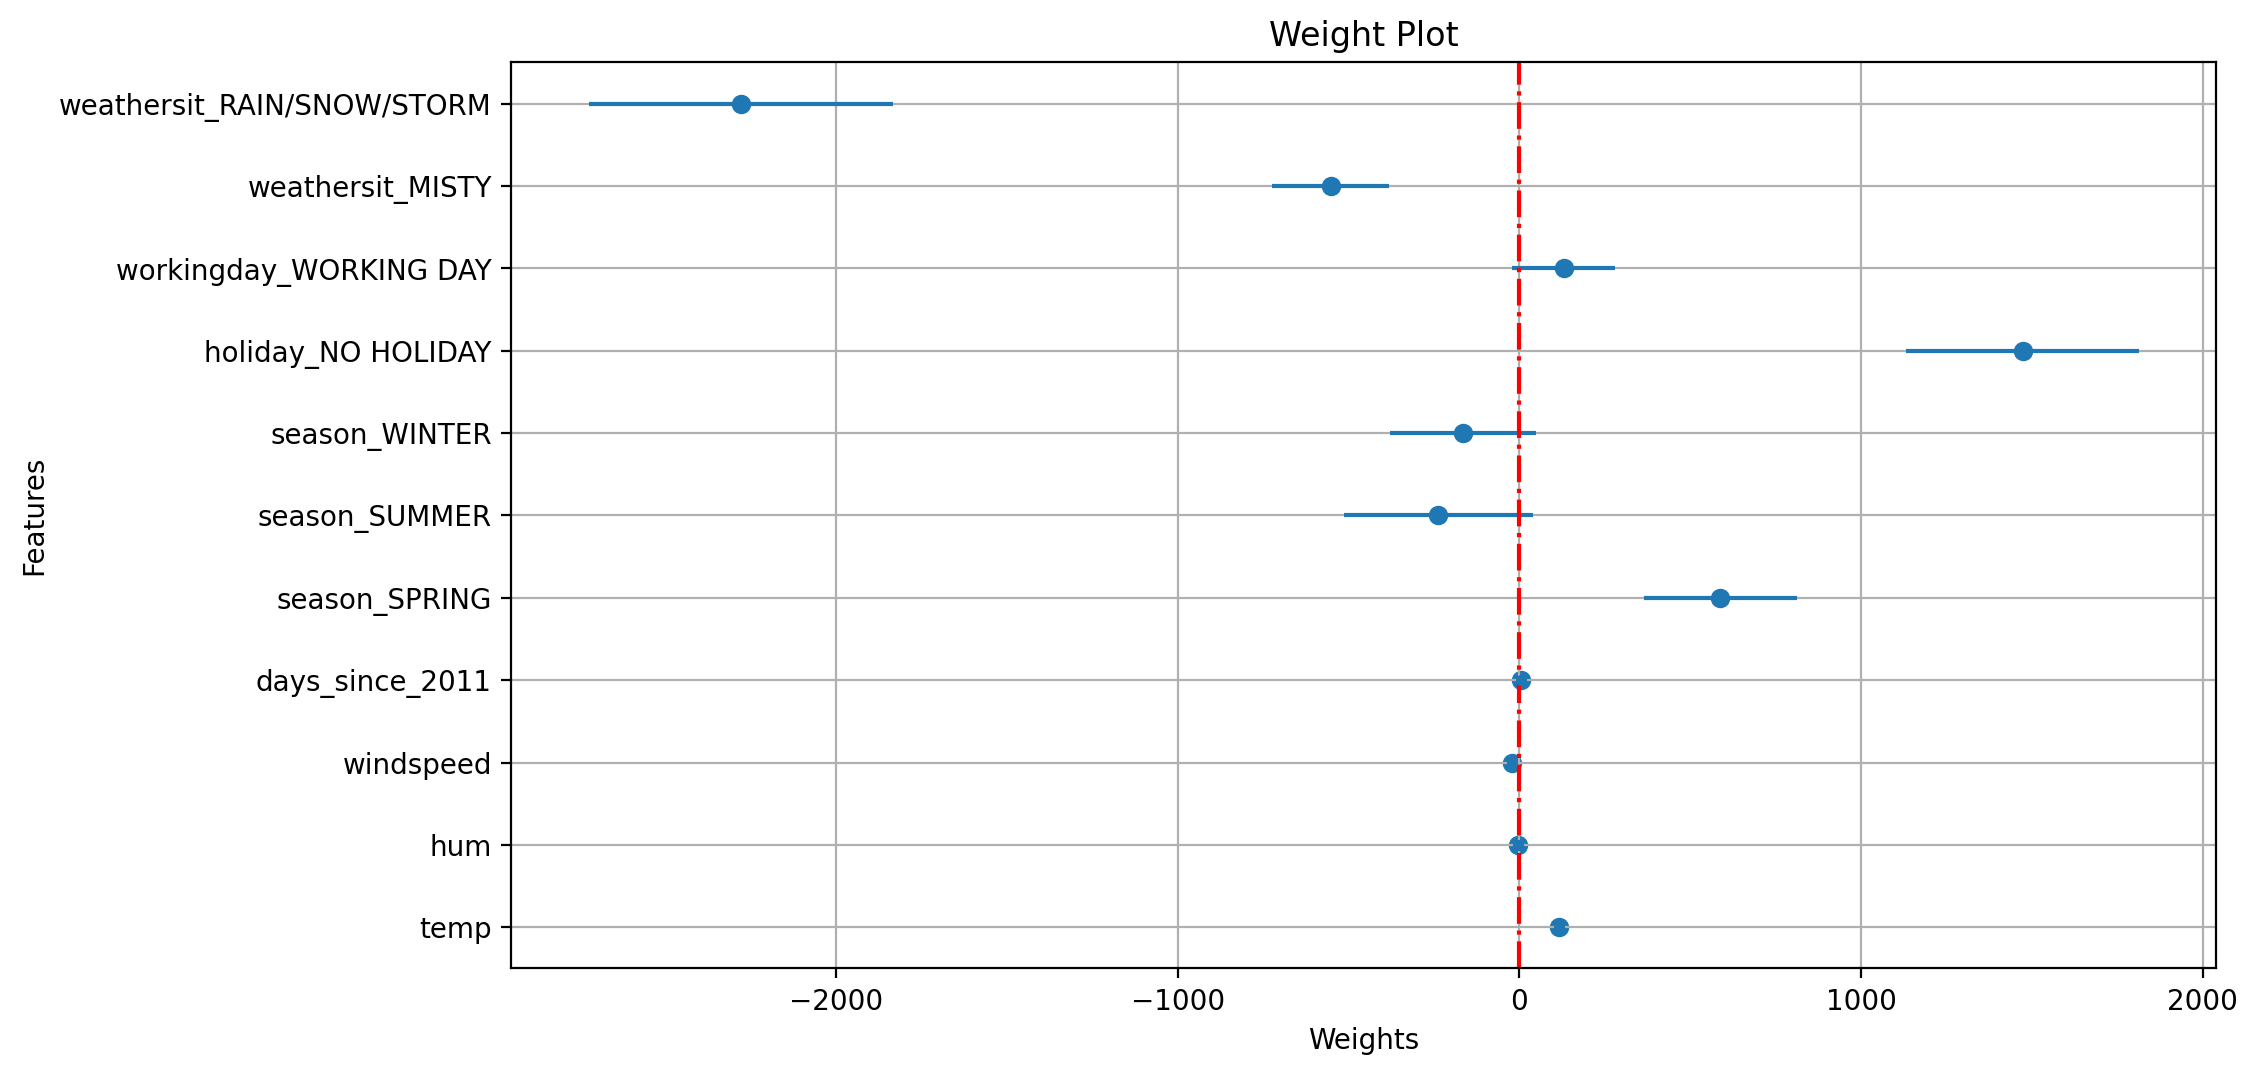

In [47]:
# Plotting the Weight Plot

plt.rcParams['figure.dpi'] = 200
fig, ax = plt.subplots(figsize=(11,6))
ax.scatter(t['coefficients'], t.index)
ax.errorbar(t['coefficients'], t.index, xerr=2*t['std_error'], fmt = '.')
ax.axvline(0, linestyle='-.', color='red')
ax.set_title("Weight Plot")
ax.set_xlabel("Weights")
ax.set_ylabel("Features")
plt.grid('True')

The Weight Plot shows that the feature, "weathersit_RAIN/SNOW/STORM", has a strong negative effect on the bike rentals. The features, "season_WINTER", "season_SUMMER", and "workingday_WORKING DAY" have coefficients where 0 falls within its 95% confidence interval. That says that the effect is not statistically significant.

## Effect Plot
The weight plot shows how much *weight* a feature has on the prediction. BUT an effect plot helps understand how much a feature contributes to the predictions. This is done by multiplying the weight by its actual feature values. 

In [48]:
for col in [col for col in df.columns if col != 'cnt']:
    df['effect_'+col] = df[col] * coef[col][0]

In [49]:
df.head()

,temp,hum,windspeed,cnt,days_since_2011,season_SPRING,season_SUMMER,season_WINTER,holiday_NO HOLIDAY,workingday_WORKING DAY,...,effect_hum,effect_windspeed,effect_days_since_2011,effect_season_SPRING,effect_season_SUMMER,effect_season_WINTER,effect_holiday_NO HOLIDAY,effect_workingday_WORKING DAY,effect_weathersit_MISTY,effect_weathersit_RAIN/SNOW/STORM
0,8.175849,80.5833,10.749882,985,0,0,0,1,1,0,...,-321.836179,-245.643108,0.000000,0.0,-0.0,-166.550381,1472.214874,0.000000,-552.965982,-0.0
1,9.083466,69.6087,16.652113,801,1,0,0,1,1,0,...,-278.005468,-380.513645,5.287075,0.0,-0.0,-166.550381,1472.214874,0.000000,-552.965982,-0.0
2,1.229108,43.7273,16.636703,1349,2,0,0,1,1,1,...,-174.639499,-380.161515,10.574150,0.0,-0.0,-166.550381,1472.214874,129.406767,-0.000000,-0.0
3,1.400000,59.0435,10.739832,1562,3,0,0,1,1,1,...,-235.809832,-245.413457,15.861224,0.0,-0.0,-166.550381,1472.214874,129.406767,-0.000000,-0.0
4,2.666979,43.6957,12.522300,1600,4,0,0,1,1,1,...,-174.513294,-286.144228,21.148299,0.0,-0.0,-166.550381,1472.214874,129.406767,-0.000000,-0.0


In [50]:
effect_columns = [col for col in df.columns if "effect_" in col]
effect_columns

['effect_temp',
 'effect_hum',
 'effect_windspeed',
 'effect_days_since_2011',
 'effect_season_SPRING',
 'effect_season_SUMMER',
 'effect_season_WINTER',
 'effect_holiday_NO HOLIDAY',
 'effect_workingday_WORKING DAY',
 'effect_weathersit_MISTY',
 'effect_weathersit_RAIN/SNOW/STORM']

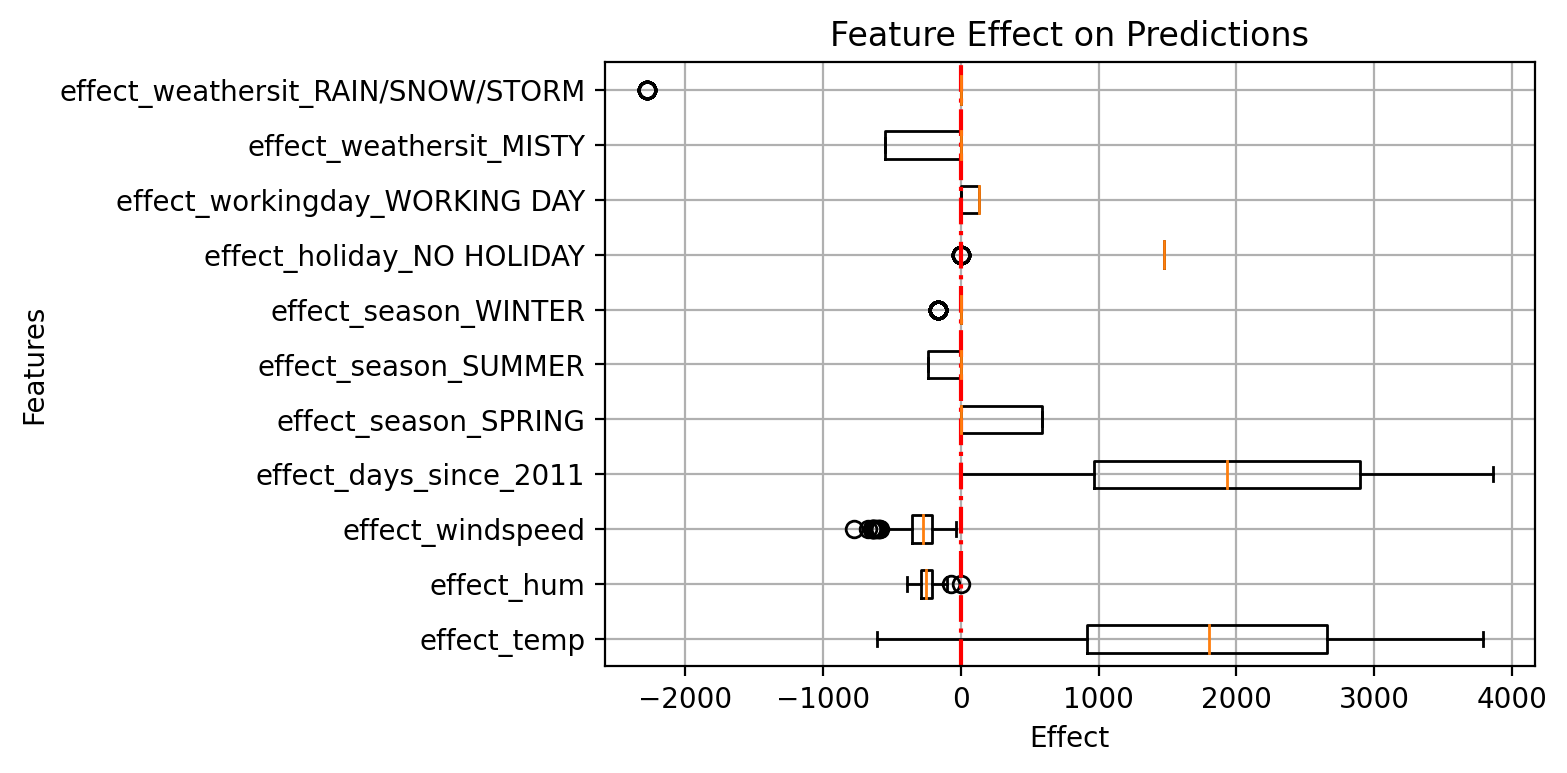

In [58]:
fig, ax = plt.subplots(1,1)

ax.boxplot(df[effect_columns], vert=False)
ax.set_yticklabels(effect_columns)
ax.axvline(0, linestyle='-.', color='red')
ax.set_ylabel("Features")
ax.set_xlabel("Effect")
ax.set_title("Feature Effect on Predictions")
plt.grid();

## Plot Individual Predictions

In [71]:
# new_observation = [1.604356, 51.8261, 6.000868, 5, 0, 0, 1, 1, 1, 0, 0]

# fig, ax = plt.subplots(1,1)
# ax.boxplot(df[effect_columns], vert=False)
# for idx, col in enumerate(effect_columns):
#     ax.annotate('x', (idx, new_observation[idx]))
# ax.set_yticklabels(effect_columns)
# ax.axvline(0, linestyle='-.', color='red')
# ax.set_ylabel("Features")
# ax.set_xlabel("Effect")
# ax.set_title("Feature Effect on Predictions")
# plt.grid();